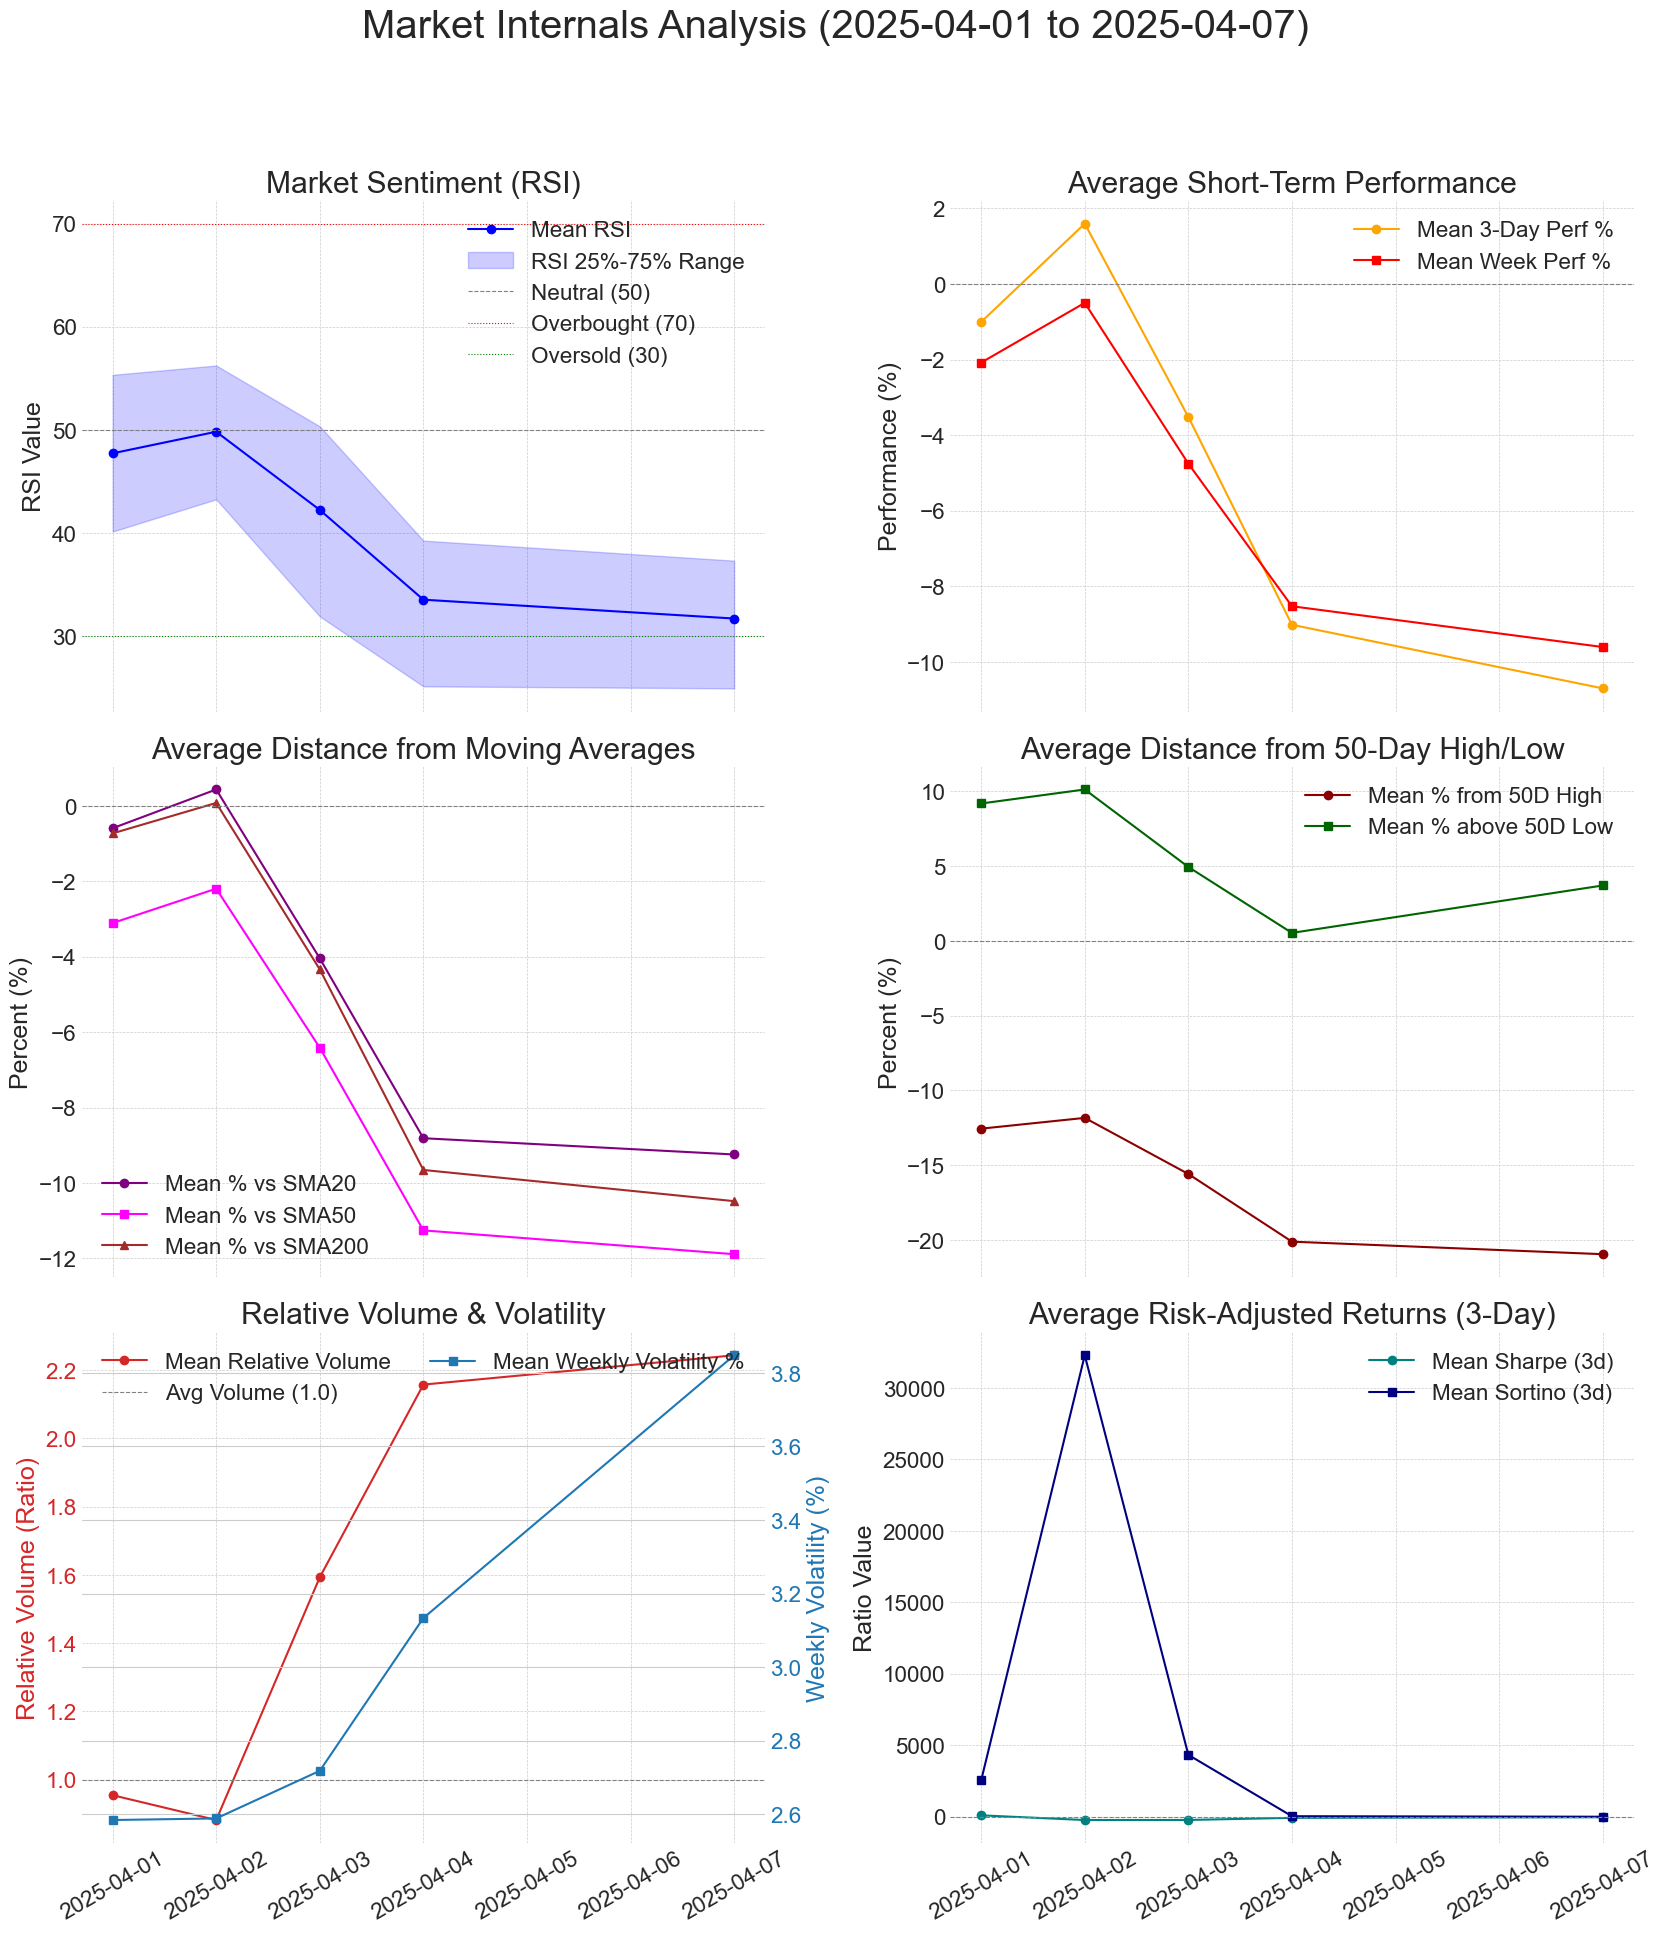

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings

# Suppress potential warnings from seaborn/matplotlib if versions are slightly off
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- Configuration ---
FILE_PATH = 'market_daily_summary_stats_history.csv'
START_DATE = '2025-04-01'
END_DATE = '2025-04-07'

# --- Font Size Configuration ---
# Adjust these values as needed
FONT_SCALE = 1.8
TITLE_FONTSIZE = 16 * FONT_SCALE  # Main title
SUBPLOT_TITLE_FONTSIZE = 12 * FONT_SCALE
AXIS_LABEL_FONTSIZE = 10 * FONT_SCALE
TICK_LABEL_FONTSIZE = 9 * FONT_SCALE
LEGEND_FONTSIZE = 9 * FONT_SCALE

# Update matplotlib's runtime configuration parameters for fonts
plt.rcParams.update({
    'font.size': TICK_LABEL_FONTSIZE,          # Default text size
    'axes.titlesize': SUBPLOT_TITLE_FONTSIZE,  # Subplot title size
    'axes.labelsize': AXIS_LABEL_FONTSIZE,     # X and Y axis labels
    'xtick.labelsize': TICK_LABEL_FONTSIZE,    # X-axis tick labels
    'ytick.labelsize': TICK_LABEL_FONTSIZE,    # Y-axis tick labels
    'legend.fontsize': LEGEND_FONTSIZE,        # Legend text
    'figure.titlesize': TITLE_FONTSIZE         # Figure title (suptitle)
})


# --- Load and Prepare Data ---
try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print(f"Error: File not found at '{FILE_PATH}'")
    exit()
except Exception as e:
    print(f"Error reading CSV file: {e}")
    exit()

# Convert 'Date' column to datetime objects
try:
    df['Date'] = pd.to_datetime(df['Date'])
except KeyError:
    print("Error: 'Date' column not found in the CSV.")
    exit()
except Exception as e:
    print(f"Error converting 'Date' column: {e}")
    exit()

# Set Date as index
df = df.set_index('Date')

# Filter for the specific date range we analyzed
df_period = df.loc[START_DATE:END_DATE].copy() # Use .copy() to avoid SettingWithCopyWarning

if df_period.empty:
    print(f"Error: No data found between {START_DATE} and {END_DATE}.")
    exit()

# --- Plotting ---
sns.set_style("whitegrid") # Use seaborn's styling for nicer plots
# plt.style.use('seaborn-v0_8-darkgrid') # You can still use this if you prefer

# Determine number of plots needed
num_plots = 6
# Increased figsize slightly to potentially accommodate larger fonts
fig, axes = plt.subplots(nrows=num_plots // 2, ncols=2, figsize=(17, 19), sharex=True)
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# --- Plot 1: Sentiment (RSI Mean and Range) ---
ax = axes[0]
ax.plot(df_period.index, df_period['RSI_mean'], label='Mean RSI', marker='o', color='blue')
ax.fill_between(df_period.index, df_period['RSI_25%'], df_period['RSI_75%'],
                color='blue', alpha=0.2, label='RSI 25%-75% Range')
ax.axhline(50, color='grey', linestyle='--', linewidth=0.8, label='Neutral (50)')
ax.axhline(70, color='red', linestyle=':', linewidth=0.8, label='Overbought (70)')
ax.axhline(30, color='green', linestyle=':', linewidth=0.8, label='Oversold (30)')
ax.set_title('Market Sentiment (RSI)') # Title size controlled by rcParams
ax.set_ylabel('RSI Value') # Label size controlled by rcParams
ax.legend() # Legend size controlled by rcParams

# --- Plot 2: Short-Term Performance ---
ax = axes[1]
ax.plot(df_period.index, df_period['Perf 3D %_mean'], label='Mean 3-Day Perf %', marker='o', color='orange')
ax.plot(df_period.index, df_period['Perf Week %_mean'], label='Mean Week Perf %', marker='s', color='red')
ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)
ax.set_title('Average Short-Term Performance')
ax.set_ylabel('Performance (%)')
ax.legend()

# --- Plot 3: Technical Health (vs SMAs) ---
ax = axes[2]
ax.plot(df_period.index, df_period['SMA20 %_mean'], label='Mean % vs SMA20', marker='o', color='purple')
ax.plot(df_period.index, df_period['SMA50 %_mean'], label='Mean % vs SMA50', marker='s', color='magenta')
ax.plot(df_period.index, df_period['SMA200 %_mean'], label='Mean % vs SMA200', marker='^', color='brown')
ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)
ax.set_title('Average Distance from Moving Averages')
ax.set_ylabel('Percent (%)')
ax.legend()

# --- Plot 4: Technical Health (vs Highs/Lows) ---
ax = axes[3]
ax.plot(df_period.index, df_period['50D High %_mean'], label='Mean % from 50D High', marker='o', color='darkred')
ax.plot(df_period.index, df_period['50D Low %_mean'], label='Mean % above 50D Low', marker='s', color='darkgreen')
ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)
ax.set_title('Average Distance from 50-Day High/Low')
ax.set_ylabel('Percent (%)')
ax.legend()

# --- Plot 5: Volume Confirmation & Volatility ---
ax = axes[4]
color = 'tab:red'
ax.set_ylabel('Relative Volume (Ratio)', color=color) # Label size controlled by rcParams
ax.plot(df_period.index, df_period['Rel Volume_mean'], label='Mean Relative Volume', marker='o', color=color)
ax.tick_params(axis='y', labelcolor=color) # Tick label size controlled by rcParams
ax.axhline(1, color='grey', linestyle='--', linewidth=0.8, label='Avg Volume (1.0)')
ax.legend(loc='upper left') # Legend size controlled by rcParams

ax2 = ax.twinx() # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Weekly Volatility (%)', color=color) # Label size controlled by rcParams
ax2.plot(df_period.index, df_period['Volatility W %_mean'], label='Mean Weekly Volatility %', marker='s', color=color)
ax2.tick_params(axis='y', labelcolor=color) # Tick label size controlled by rcParams
ax2.legend(loc='upper right') # Legend size controlled by rcParams
ax.set_title('Relative Volume & Volatility') # Title size controlled by rcParams

# --- Plot 6: Risk-Adjusted Returns (Short Term) ---
ax = axes[5]
ax.plot(df_period.index, df_period['Sharpe 3d_mean'], label='Mean Sharpe (3d)', marker='o', color='teal')
ax.plot(df_period.index, df_period['Sortino 3d_mean'], label='Mean Sortino (3d)', marker='s', color='navy')
ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)
ax.set_title('Average Risk-Adjusted Returns (3-Day)')
ax.set_ylabel('Ratio Value')
ax.legend()


# --- Final Touches ---
# Improve date formatting on x-axis
for ax in axes:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)) # Tick mark for every day
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Format as YYYY-MM-DD
    ax.tick_params(axis='x', rotation=30) # Rotate labels slightly. Size controlled by rcParams
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set the main title - size is now controlled by rcParams 'figure.titlesize'
plt.suptitle('Market Internals Analysis (2025-04-01 to 2025-04-07)', y=1.02) # Removed fontsize argument here
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()